In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys, shutil
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
import json
import importlib
sys.path.insert(0, '../utils')
import data_utils, run_utils, models

#### WNET

In [2]:
'''
Quickly summarize trained models
Note on naming scheme
    For input info changes: flux=X (29,31), time_series=T (34), mag=M
    For feat changes: _1, _2 (e.g. med vs med**2 TS 40_5 vs 20_5)
    For train params (loss term wght, loss chan wght, lr) changes: _A, _B, etc 
    For model params (pad and kernel size) changes: _a, _b, etc 
'''

importlib.reload(run_utils)
mods = run_utils.get_modelsDF(taskdir='../../WNet_runs/MURaM')
mods

Skipping WNetX_1Bb; not finished training


,WNet_name,n_classes,channels,weights,smth_wgt,blb_wgt,nct_wgt,pad_mode,ne,lr,k_size,task_dir
1,WNetM_1A,3,"[X, Bz]","[1, 1]",1.0,0.0,1,replicate,6,0.100,3,NaN
5,WNetM_1A_again,3,"[X, Bz]","[1, 1]",1.0,1.0,1,replicate,6,0.100,3,NaN
2,WNetM_1B,3,"[X, Bz]","[1, 2]",1.0,1.0,1,replicate,6,0.100,3,NaN
11,WNetM_1C,3,"[X, Bz]","[1, 1.5]",1.5,1.0,1,replicate,6,0.100,3,NaN
8,WNetM_1D,3,"[X, Bz]","[1, 1.5]",1.0,1.0,1,replicate,6,0.100,3,NaN
3,WNetM_1E,3,"[X, Bz]","[1, 2]",10.0,1.0,1,replicate,6,0.100,3,MURaM
19,WNetT_1A,3,[TS40_5],"[1, 1, 1, 1, 1]",10.0,0.0,1,replicate,10,0.100,3,NaN
15,WNetT_1B,3,[TS40_5],"[1, 1, 1, 1, 1]",10.0,1.0,1,replicate,10,0.100,3,NaN
16,WNetT_1C,3,[TS40_5],"[1, 1, 1, 1, 1]",10.0,10.0,1,replicate,10,0.100,3,NaN
14,WNetT_1D,3,[TS40_5],"[1, 1, 1, 1, 1]",10.0,10000.0,1,replicate,10,0.100,3,NaN


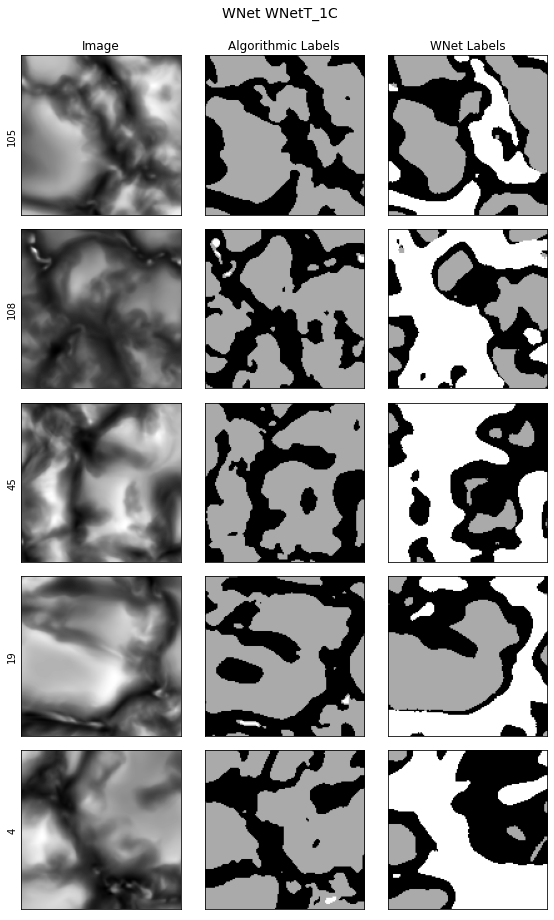

In [30]:
'''
Display a random sample of images for one model
'''

WNet_num = 'WNetT_1C' 
output_dir = f'../../WNet_runs/MURaM/{WNet_num}/test_preds_MURaM'
fig, axs = plt.subplots(5, 3, figsize=(8, 13))
axs[0,0].set_title('Image')
axs[0,1].set_title('Algorithmic Labels')
axs[0,2].set_title('WNet Labels')
target_pos = 2 if 'timeseries' in mods[mods['WNet_name']==f"WNet{WNet_num}"] else 0
for i in range(5): 
    idx = np.random.randint(0, len([file for file in os.listdir(output_dir) if file.startswith('x')]))
    im = np.load(f'{output_dir}/x_{idx}.npy')[target_pos]
    algseg = np.load(f'{output_dir}/true_{idx}.npy')
    preds = np.squeeze(np.load(f'{output_dir}/pred_{idx}.npy'))
    axs[i,0].imshow(im, cmap='gist_gray'); axs[i,0].set_ylabel(idx)
    axs[i,1].imshow(algseg, vmin=0, vmax=1.5, cmap='gist_gray')
    axs[i,2].imshow(preds, vmin=0, vmax=1.5, cmap='gist_gray')
    axs[i,0].xaxis.set_tick_params(labelbottom=False); axs[i,0].yaxis.set_tick_params(labelleft=False); axs[i,0].set_xticks([]); axs[i,0].set_yticks([])
    axs[i,1].xaxis.set_tick_params(labelbottom=False); axs[i,1].yaxis.set_tick_params(labelleft=False); axs[i,1].set_xticks([]); axs[i,1].set_yticks([])
    axs[i,2].xaxis.set_tick_params(labelbottom=False); axs[i,2].yaxis.set_tick_params(labelleft=False); axs[i,2].set_xticks([]); axs[i,2].set_yticks([])
plt.suptitle(f'WNet {WNet_num}\n', fontsize=14)
plt.tight_layout()
plt.savefig(f'{output_dir}/WNet{WNet_num}_val_examples')

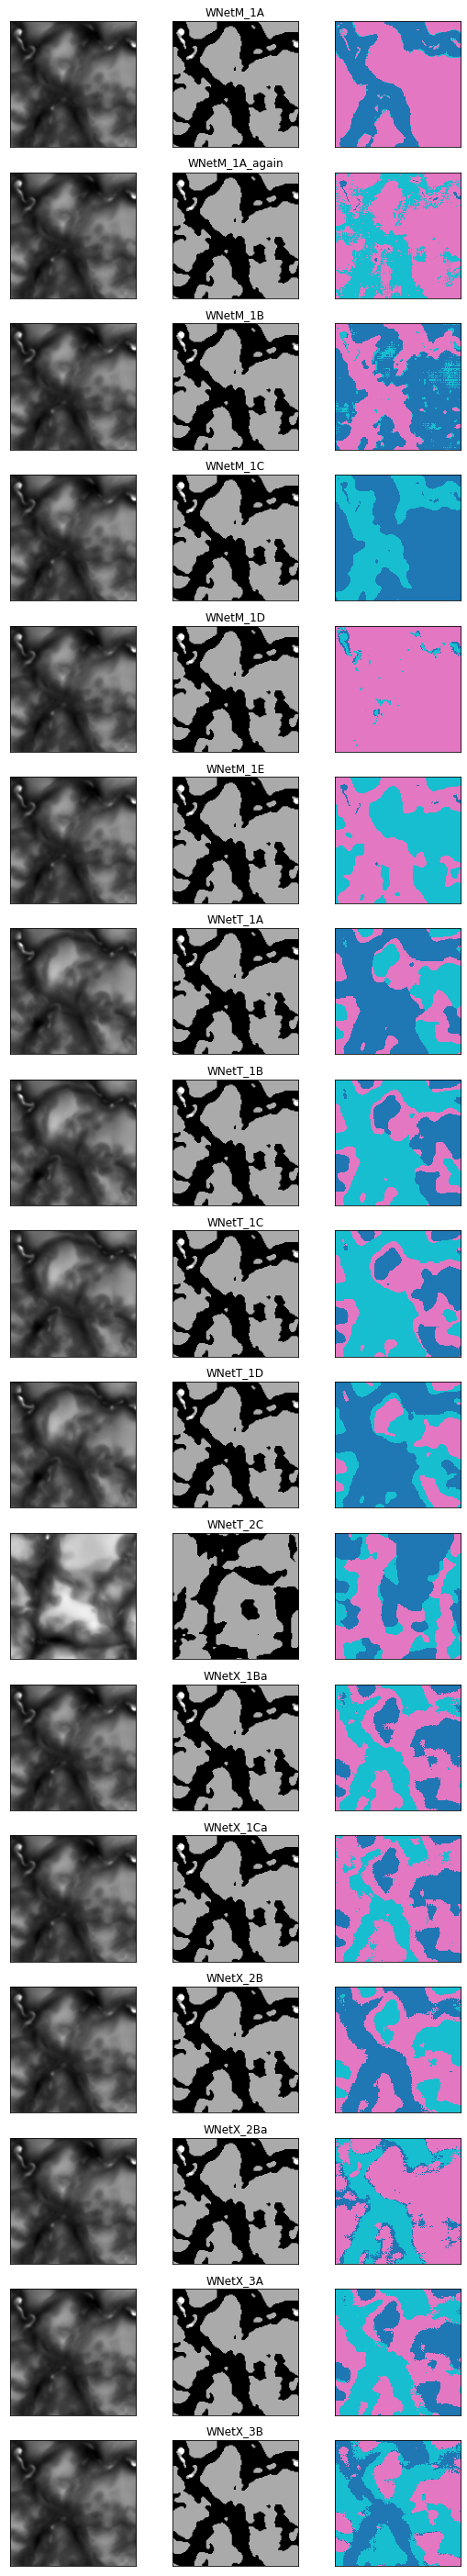

In [5]:
'''
Compare models
'''

ts40idx = 108 # 58
ts80idx = 20 # FIND A GOOD ONE
nontsidx = 692 # 51, 131 # 161  # 131 # dont want to go through timeseries test sets to actually find the imageset that whose target image is idx 131 in the non-TS test set
ignore = ['WNetX_2Aa', 'WNetX_1B', 'WNetX_2A','WNetX_1A']
ms = [m for m in mods['WNet_name'] if m not in ignore] # [n.replace('WNet','') for n in mods['WNet_name']] # ['29nm','29nm_a','32nm','32nm_a','33nm','34nm','34nm_a'] # models on properly normalized data!
fig, axs = plt.subplots(len(ms), 3, figsize=(9, 3*len(ms)))
for i in range(len(ms)):
    output_dir = f'../../WNet_runs/MURaM/{ms[i]}/test_preds_MURaM'
    target_pos = 2 if ms[i]=='WNet15m' else 0
    idx = ts40idx if 'T_1' in ms[i] else ts80idx if 'T_2' in ms[i] else nontsidx 
    im = np.load(f'{output_dir}/x_{idx}.npy')[target_pos] # index to get image
    algseg = np.load(f'{output_dir}/true_{idx}.npy')
    preds = np.squeeze(np.load(f'{output_dir}/pred_{idx}.npy'))
    if int(preds[40, 60]) == 0: # try to mostly have black be zero
        preds_copy = np.copy(preds)
        preds[preds_copy == 0.0] = 1
        preds[preds_copy == 1.0] = 0 
    axs[i,1].set_title(f'{ms[i]}')
    axs[i,0].imshow(im, cmap='gist_gray')
    axs[i,1].imshow(algseg, vmin=0, vmax=1.5, cmap='gist_gray')
    axs[i,2].imshow(preds, vmin=0, vmax=1.5, interpolation='none', cmap='tab10') #cmap='gist_gray')#cmap='tab10')
    axs[i,0].xaxis.set_tick_params(labelbottom=False); axs[i,0].yaxis.set_tick_params(labelleft=False); axs[i,0].set_xticks([]); axs[i,0].set_yticks([])
    axs[i,1].xaxis.set_tick_params(labelbottom=False); axs[i,1].yaxis.set_tick_params(labelleft=False); axs[i,1].set_xticks([]); axs[i,1].set_yticks([])
    axs[i,2].xaxis.set_tick_params(labelbottom=False); axs[i,2].yaxis.set_tick_params(labelleft=False); axs[i,2].set_xticks([]); axs[i,2].set_yticks([])
plt.savefig('ExamplePredictions_OneImage.png')

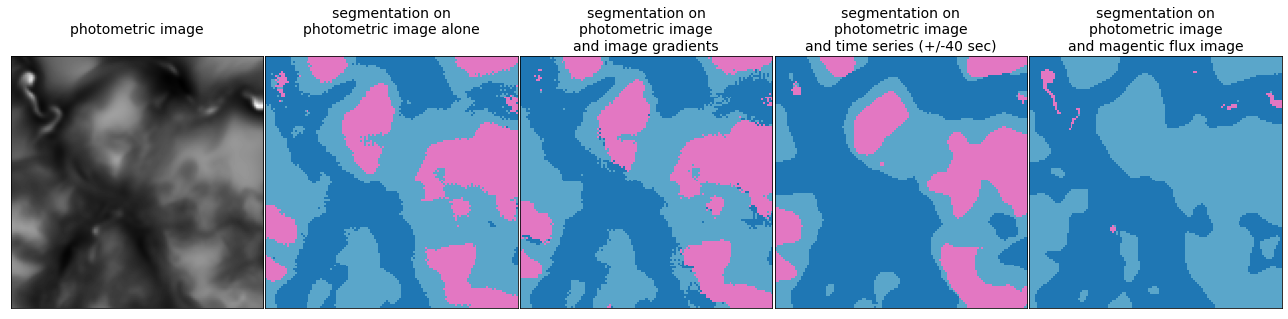

In [32]:
'''
Nice plots for poster
'''

ms = ['WNetX_1Ba','WNetX_3A', 'WNetT_1C','WNetM_1E']
colors = LinearSegmentedColormap.from_list('', [plt.cm.tab10(0), plt.cm.tab10(9), plt.cm.tab10(6)]) #  (note that in tab10, order is dark blue, pink, light blue)
orientation = 'horiz'
if orientation == 'horiz':
    descs = {'WNetX_1Ba':'segmentation on\nphotometric image alone\n',
             'WNetX_2Ba':'segmentation on\nphotometric image\nand median filtered image',
             'WNetX_3A':'segmentation on\nphotometric image\nand image gradients',
             'WNetT_1C':'segmentation on\nphotometric image\nand time series (+/-40 sec)',
             'WNetM_1E':'segmentation on\nphotometric image\nand magentic flux image'}
if orientation == 'vert':
    descs = {'WNetX_1Ba':'\n\n\n\n\n\nsegmentation\non photometric\nimage alone',
             'WNetX_2Ba':'\n\n\n\n\n\nsegmentation\non photometric\nimage and\nmedian\nfiltered\nimage',
             'WNetX_3A':'\n\n\n\n\n\nsegmentation\non photometric\nimage and\nimage\ngradients',
             'WNetT_1C':'\n\n\n\n\n\nsegmentation\non photometric\nimage and\ntime series\n(+/-40 sec)',
             'WNetM_1E':'\n\n\n\n\n\nsegmentation\non photometric\nimage and\nmagentic\nflux image'}
if orientation == 'sqaure':
    descs = {'WNetX_1Ba':'segmentation on\nphotometric image alone',
             'WNetX_2Ba':'segmentation on\nphotometric image and\nmedian filtered image',
             'WNetX_3A':'segmentation on\nphotometric image and\nimage gradients',
             'WNetT_1C':'segmentation on\nphotometric image and\ntime series (+/-40 sec)',
             'WNetM_1E':'segmentation on\nphotometric image and\nmagentic flux image'}
    
tsidx = 108 # 58
nontsidx = 692 # 58 # change this if I find a match..
im = np.load(f'../../WNet_runs/MURaM/WNetM_1A/test_preds_MURaM/x_{nontsidx}.npy')[0]
algseg = np.load(f'../../WNet_runs/MURaM/WNetM_1A/test_preds_MURaM/true_{nontsidx}.npy')
if orientation == 'horiz':
    fig, axs = plt.subplots(1, len(ms)+1, figsize=(4.5*len(ms),4.5))
    axs[0].imshow(im, cmap='gist_gray')
    axs[0].set_title('photometric image\n', fontsize=14)
if orientation == 'vert':
    fig, axs = plt.subplots(len(ms)+1, 1, figsize=(4.5, 4.5*len(ms)))
    axs[0].imshow(im, cmap='gist_gray')
    axs[0].set_ylabel('photometric\nimage', rotation=0, labelpad=60, fontsize=14)
if orientation == 'sqaure':
    fig, axs = plt.subplots(2, len(ms), figsize=(9, 2.6*len(ms)))
    axs[0,1].imshow(im, cmap='gist_gray')
    axs[0,1].set_title('photometric image', fontsize=14)
    axs[0,0].axis('off'); axs[0,2].axis('off')
#axs[1].imshow(algseg, vmin=0, vmax=1.5, cmap='gist_gray')
#axs[1].set_title('Algorithmic segmentation')
for i in range(len(ms)):
    idx = tsidx if 'T' in ms[i] else nontsidx  
    preds = np.squeeze(np.load(f'../../WNet_runs/MURaM/{ms[i]}/test_preds_MURaM/pred_{idx}.npy'))
    # Hacky way to *try* to set dark blue for igr, light blue gr, pink bp [for some reason class nums are same for all T and all M models]
    out = np.empty_like(preds)
    if 'T' in ms[i]:
        out[preds == 1.5] = 0.0
        out[preds == 0.0] = 1.0
        out[preds == 1.0] = 1.5
    if 'M' in ms[i]:
        out[preds == 1.0] = 0.0
        out[preds == 1.5] = 1.0
        out[preds == 0.0] = 1.5
    if 'X' in ms[i]:
        out[preds == 1.5] = 0.0
        out[preds == 0.0] = 1.0
        out[preds == 1.0] = 1.5
    if orientation == 'horiz':
        axs[i+1].set_title(f'{descs[ms[i]]}', fontsize=14)
        axs[i+1].imshow(out, vmin=0, vmax=1.5, interpolation='none', cmap=colors) #cmap='gist_gray')#cmap='tab10')
    if orientation == 'vert':
        axs[i+1].set_ylabel(f'{descs[ms[i]]}', rotation=0, labelpad=60, fontsize=14)
        axs[i+1].imshow(out, vmin=0, vmax=1.5, interpolation='none', cmap=colors) #cmap='gist_gray')#cmap='tab10')
    if orientation == 'sqaure':
        axs[1,i].set_title(f'{descs[ms[i]]}', fontsize=14)
        axs[1,i].imshow(out, vmin=0, vmax=1.5, interpolation='none', cmap=colors) #cmap='gist_gray')#cmap='tab10')
for ax in axs.flat:
    ax.xaxis.set_tick_params(labelbottom=False); ax.yaxis.set_tick_params(labelleft=False); ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig('ExamplePredictions_OneImage.png')


In [2]:
'''
Run WNet in notebook for debugging
'''
sys.path.insert(0, '../')
import run_WNet
importlib.reload(data_utils)
importlib.reload(run_WNet)

exp_dicts = json.load(open('../../Solar_Segmentation/exp_file_2.json'))
if isinstance(exp_dicts, dict): # If experiment file is a single dict, not a list of dicts
    exp_dicts = [exp_dicts]
for d in exp_dicts:
    print(f'RUNNING EXPERIMENT {d["WNet_name"]} \nexp dict: {d}')
    run_WNet.run_wnet_model(d, gpu='False')
    print(f'DONE')
print('FINISHED ALL EXPERIMENTS')

RUNNING EXPERIMENT WNetX_1Bb 
exp dict: {'task_dir': 'MURaM', 'WNet_name': 'WNetX_1Bb', 'n_classes': 3, 'channels': ['X'], 'weights': [1], 'img_dir': '../Data/UNetData_MURaM/norm_images/', 'seg_dir': '../Data/UNetData_MURaM/seg_images/', 'img_size': 128, 'randomSharp': 'False', 'smooth_wght': 10, 'blob_wght': 0, 'ncut_wght': 1, 'kernel_size': 5, 'padding_mode': 'replicate', 'num_epochs': 10, 'batch_size': 16, 'learning_rate': 0.001}
Experiment output dir ../../WNet_runs/MURaM/WNetX_1Bb/ already exists - contents will be overwritten
Copying exp dict into ../../WNet_runs/MURaM/WNetX_1Bb//exp_file.json
Loading data from ../../Data/UNetData_MURaM/norm_images/
Train data:
     1890 obs, broken into 119 batches
     Each batch has data of shape torch.Size([16, 1, 128, 128]), e.g. 16 images, [128, 128] pixels each, 1 layers (features)
     Each batch has labels of shape torch.Size([16, 3, 128, 128]), e.g. 16 images, [128, 128] pixels each, 3 layers (classes)
Training WNetX_1Bb (training on cp

NameError: name 'b' is not defined

#### Traditional 

In [ ]:
# Get data
path = "../Data/All_DKIST/FirstLight.fits"
data = fits.open(path)[0].data
labels = np.squeeze(fits.open("../Data/All_DKIST/SEGv2_FirstLight")[0].data) # just to check against

# Cut and flatten
data = data[100:300, 100:300]
labels = labels[100:300, 100:300]
dataflat = data.reshape(-1)

# Plot for comparison
plt.figure(figsize=(3, 3))
plt.imshow(data, cmap='gray', origin='lower')
plt.title('Initial data (HE)')
plt.figure()

# Create features and put into df (skip kernel feature for now - contain inf and probably not super useful anyway)
df = pd.DataFrame()
df['OG_value'] = dataflat
df = data_utils.add_gradient_feats(df, data) # Add value of (non-HE) gradient as feature
df = data_utils.add_sharpening_feats(df, dataflat) # Add value of sharpening filters as features RIGHT NOW JUST SQUARED

In [ ]:
'''
KMeans (best)
    Clusters by separating into n groups of equal variance, minimizing within-cluster sum-of-squares
    Overall, this seems to overestimate IGM
    Could try using large n_clusters, then combineing.
'''

from sklearn.cluster import KMeans

# Explore hyperparameters
n_clusterss = [2, 3, 5, 7]
inits = ['k-means++', 'random'] # can also try passing locs of centers if use another alg to determine

dict = {}
i = 0
for n_clusters in n_clusterss:
    for init in inits:
        preds_flat = KMeans(n_clusters=n_clusters, init=init, n_init=10).fit(df.values).labels_
        preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
        preds = data_utils.post_process(preds) # make sure IG is assigned to 0, G to 1
        dict[str(i)] = [n_clusters, init, preds]
        i += 1
        pct_correct = len(np.where(preds.reshape(-1)==labels.reshape(-1))[0])/len(preds.reshape(-1))
        print('    n_clusters='+str(n_clusters)+', init='+str(init)+ ', "accuracy":', pct_correct)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
fig.suptitle('KMeans')
axs = [ax1, ax2]
for i in range(len(axs)):
    n_clusters =  dict[str(i)][0]
    init = dict[str(i)][1]
    preds = dict[str(i)][2]
    axs[i].imshow(preds, origin='lower')
    axs[i].set_title('n_clusters='+str(n_clusters)+', init='+str(init))


# With "best" hyperparameters
n_clusters = 7
preds_flat = KMeans(n_clusters=n_clusters, init='random', n_init=10).fit(df.values).labels_
preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))

def kmeans_to_seg(preds, data, resolution=0.016, bp_max_size=0.15):
    seg = np.zeros_like(data)*np.NaN
    # HE
    data_norm = ((data - np.nanmin(data))/(np.nanmax(data) - np.nanmin(data))) * 225 # min-max normalization to [0, 225] 
    data_HE = sk.filters.rank.equalize(data_norm.astype(int), footprint=sk.morphology.disk(250))
    data_HE = data_HE[100:300, 100:300]
    bp_min_pix = (bp_max_size / resolution)**2 # 87
    bp_min_flux = np.nanmean(data) + 0.25 * np.nanstd(data) 
    ig_max_flux = np.nanmean(data) - 0.25 * np.nanstd(data)
    labeled_preds = skimage.measure.label(preds + 1, connectivity=2)
    values = np.unique(labeled_preds) 
    for value in values:
        datavals = data[labeled_preds == value].flatten()
        if (np.nanmean(datavals) <= ig_max_flux):
            seg[labeled_preds == value] = 0
        if (np.nanmean(datavals) > ig_max_flux): #and (len(datavals) > bp_min_pix): #(np.nanmean(datavals) < bp_min_flux):
            seg[labeled_preds == value] = 1
            if (len(datavals) < bp_min_pix) and np.max(datavals) > bp_min_flux:
                seg[labeled_preds == value] = 1.5
    return seg

seg = kmeans_to_seg(preds, data)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.5))
fig.suptitle('KMeans (n_clusters=7, init="random")')
ax1.imshow(data, cmap='gray', origin='lower'); ax1.set_title('data')
ax2.imshow(preds, origin='lower'); ax2.set_title('kmeans preds')
ax3.imshow(seg, origin='lower'); ax3.set_title('kmeans pred -> seg')
fig, axs = plt.subplots(n_clusters, 1, figsize=(7, 2*n_clusters))
i = 0
axs[-1].set_ylabel('Flux')
for group in np.unique(preds):
    axs[i].hist(data[preds == group], bins=20); axs[i].set_ylabel(f'Group {i}')
    i += 1


In [ ]:
'''
Agglomorative Clustering
    Build clusters by finding closest pairs, merging iteratively 
    Does best with 3 clusters, 'complete' linkage, 'euclidean' metric:
    Without gradient feature, 3rd cluster becomes rings around granules, not brightpoints
    With gradient feature, maybe finds dim middles?
'''

from sklearn.cluster import AgglomerativeClustering

# Explore hyperparameters
n_clusterss = [2, 3] 
metrics = ['euclidean'] #  'l1', 'manhattan' seem to do similarly (at least with n_clusters=2) 
linkages = ['complete', 'ward'] # 'average' and 'single' do terrible

dict = {}
i = 0
for n_clusters in n_clusterss:
    for metric in metrics:
        for linkage in linkages:
            preds_flat = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage=linkage).fit(df.values).labels_
            preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
            preds = data_utils.post_process(preds) # make sure IG is addigned to 0, G to 1
            dict[str(i)] = [n_clusters, metric, linkage, preds]
            i += 1
            pct_correct = len(np.where(preds.reshape(-1)==labels.reshape(-1))[0])/len(preds.reshape(-1))
            print('    n_clusters='+str(n_clusters)+', linkage='+str(linkage)+ ', "accuracy":', pct_correct)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
fig.suptitle('AgglomorativeClustering')
axs = [ax1, ax2]
for i in range(len(axs)):
    n_clusters =  dict[str(i)][0]
    metric = dict[str(i)][1]
    linkage = dict[str(i)][2]
    preds = dict[str(i)][3]
    axs[i].imshow(preds, origin='lower')
    axs[i].set_title('n_clusters='+str(n_clusters)+', linkage='+str(linkage))

In [ ]:
'''
DBSCAN 
    Clusters by identifying areas of high density separated by areas of low density 
    MUCH faster than OPTICS, but same very "poor" results
'''

from sklearn.cluster import DBSCAN

# Explore hyperparameters
epss = [10, 30] # must be larger for more features (0.5 works fine for 1 feature)
min_sampless = [50, 100, 200]
metric = 'euclidean'
algorithm = 'auto'

dict = {}
i = 0
for eps in epss:
    for min_samples in min_sampless:
        preds_flat = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm, n_jobs=3).fit(df.values).labels_
        preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
        dict[str(i)] = [eps, min_samples, preds]
        i += 1

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('DBSCAN', color='white')
axs = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in range(len(axs)):
    eps =  dict[str(i)][0]
    min_samples = dict[str(i)][1]
    preds = dict[str(i)][2]
    axs[i].imshow(preds, origin='lower')
    axs[i].set_title('eps='+str(eps)+', min_samps='+str(min_samples), color=tc)

#### MISC

In [94]:
'''
Calculate padding size for given kernel to keep dims same
    out_dim = ((input_dim - kernel_size + 2*padding)/stride) + 1 --> ((input_dim -1)*stride - input_dim + kernel_size)/2 = padding
    So with stride = 1, need padding = (kernel_size - 1)/2
What about output_padding in conv transpose?
    Needs to be 1 when kernel_size is 3, needs to be 0 when kernel_size is 5..
'''

kernel_size = 5
padding = int((kernel_size - 1)/2)

inp = torch.rand(16,3,128,128)
conv = torch.nn.Conv2d(3, 64, kernel_size=kernel_size, padding=padding, stride=1) #torch.nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=1)
out = conv(inp) 
print(inp.shape)
print(out.shape)

'''
output_size = stride × (input_size−1) + kernel_size−2 × padding + output_padding
    e.g. output_padding = input_dim - kernel_size*padding - stride*(input_dim-1) 
output_size = stride × (input_size−1) + effective_kernel_size−2 × padding + output_padding
    e.g. output_padding = input_dim - stride*(input_dim - 1) - eff_kernel_size + 2*padding
                          input_dim − stride×(input_size - 1)−effective_kernel_size+2×padding
'''

# dilation = 1  # NOTE: could perhaps use a dilation factor in the "up" layers instead of using ConvTranspose layers
output_padding = 
convtransp = torch.nn.ConvTranspose2d(64, 3, kernel_size=kernel_size, padding=padding, stride=2, output_padding=output_padding) 
rec_inp = convtransp(out)
print(rec_inp.shape)

torch.Size([16, 3, 128, 128])
torch.Size([16, 64, 128, 128])
torch.Size([16, 3, 256, 256])


In [21]:
'''
Rename models
    For input info changes: flux=X (29,31), time_series=T (34), mag=M
    For feat changes: _1, _2 (e.g. med vs med**2 TS 40_5 vs 20_5)
    For train params (loss term wght, loss chan wght, lr) changes: _A, _B, etc 
    For model params (pad and kernel size) changes: _a, _b, etc 
    Add subfolders to seperate DS used 
'''

# # Remove name labels on saved epoch predictions and losses so that only need to re-name exp folders
# exp_folders = [f for f in os.listdir('../../WNet_runs/') if 'nm' in f]
# for exp_folder in exp_folders:
#     pngs = [f for f in os.listdir(f'../../WNet_runs/{exp_folder}/') if '.png' in f]
#     for png in pngs:
#         new_name = png[png.find("_e")+1:] # oops?
#         os.rename(f'../../WNet_runs/{exp_folder}/{png}', f'../../WNet_runs/{exp_folder}/{new_name}')
#         pngs = [f for f in os.listdir(f'../../WNet_runs/{exp_folder}/') if '.png' in f]
#     name = exp_folder.replace('exp','')
#     try:
#         os.rename(f'../../WNet_runs/{exp_folder}/WNet{name}_n_cut_losses.npy', f'../../WNet_runs/{exp_folder}/n_cut_losses.npy')
#         os.rename(f'../../WNet_runs/{exp_folder}/WNet{name}_rec_losses.npy', f'../../WNet_runs/{exp_folder}/rec_losses.npy')
#     except FileNotFoundError: continue
        
# Rename exp folders 
# shutil.move('../../WNet_runs/exp29nm','../../WNet_runs/MURaM/WNetX_1A')
# shutil.move('../../WNet_runs/exp29nm_a','../../WNet_runs/MURaM/WNetX_1B')
# shutil.move('../../WNet_runs/exp29nm_b','../../WNet_runs/MURaM/WNetX_1Ba')
# shutil.move('../../WNet_runs/exp31nm','../../WNet_runs/MURaM/WNetX_2Aa')
# shutil.move('../../WNet_runs/exp31nm_a','../../WNet_runs/MURaM/WNetX_2Ba')
# shutil.move('../../WNet_runs/exp32nm','../../WNet_runs/MURaM/WNetX_2A')
# shutil.move('../../WNet_runs/exp32nm_a','../../WNet_runs/MURaM/WNetX_2B')
# #shutil.move('../../WNet_runs/exp33nm','../../WNet_runs/MURaM/WNetX_1Aa')
# shutil.move('../../WNet_runs/exp34nm','../../WNet_runs/MURaM/WNetT_1A')
# shutil.move('../../WNet_runs/exp34nm_a','../../WNet_runs/MURaM/WNetT_1B')
# shutil.move('../../WNet_runs/exp34nm_b','../../WNet_runs/MURaM/WNetT_1C')
# shutil.move('../../WNet_runs/exp34nm_c','../../WNet_runs/MURaM/WNetT_1D')
# shutil.move('../../WNet_runs/exp35nm','../../WNet_runs/MURaM/WNetM_1A')
# shutil.move('../../WNet_runs/exp35nm_a','../../WNet_runs/MURaM/WNetM_1B')
# shutil.move('../../WNet_runs/exp35nm_b','../../WNet_runs/MURaM/WNetM_1A_again')
# shutil.move('../../WNet_runs/exp35nm_c','../../WNet_runs/MURaM/WNetM_1C')
# shutil.move('../../WNet_runs/exp35nm_d','../../WNet_runs/MURaM/WNetM_1D')
# shutil.move('../../WNet_runs/exp29nm_b1','../../WNet_runs/MURaM/WNetX_1Bb')

# Move old exp folders
old_exps = [f for f in os.listdir('../../WNet_runs/') if 'exp' in f and os.path.isdir(f'../../WNet_runs/{f}')]
for old_exp in old_exps:
    shutil.move(f'../../WNet_runs/{old_exp}', f'../../WNet_runs/OLD/{old_exp}')

1.0 0.0 1.5


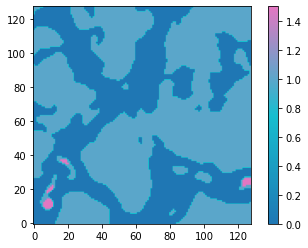

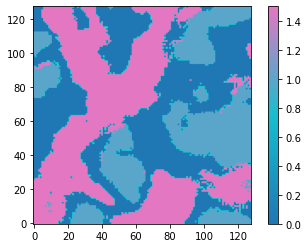

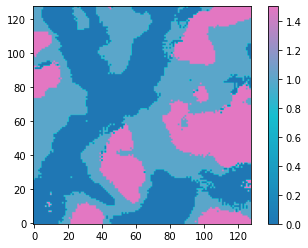

In [14]:
'''
Hacky way to *try* to set dark blue for igr, light blue gr, pink bp
'''
algseg = np.load(f'../../WNet_runs/MURaM/WNetM_1A/test_preds_MURaM/true_692.npy')
colors = LinearSegmentedColormap.from_list('', [plt.cm.tab10(0), plt.cm.tab10(9), plt.cm.tab10(6)])
plt.figure(); plt.imshow(algseg, origin='lower', cmap=colors)#'gist_gray')
plt.colorbar()
print(algseg[75, 5], algseg[0,0], algseg[9, 9])


for m in ['WNetX_3A']: #['WNetM_1E']: # 'WNetT_1C'
    idx = 108 if 'T' in m else 692
    preds = np.squeeze(np.load(f'../../WNet_runs/MURaM/{m}/test_preds_MURaM/pred_{idx}.npy'))
    plt.figure(); im0 = plt.imshow(preds, origin='lower', cmap=colors); plt.colorbar(im0)
# #     fig, axs = plt.subplots(1,4,figsize=(15, 3))
# #     im0 = axs[0].imshow(preds, origin='lower', cmap=colors); plt.colorbar(im0)
# #     preds_copy = np.copy(preds)
# #     if preds_copy[0,0] != 0.0: 
# #         print(f'preds_copy[0.0] = {preds_copy[0,0]}, not 0, so setting preds to 0 where preds_copy is {preds_copy[0,0]}')
# #         igr_num = preds_copy[0,0]
# #         preds[preds_copy == igr_num] = 0.0
# #     axs[1].imshow(preds, origin='lower', cmap=colors)
# #     if preds_copy[75,5] != 1.0: #[80,0] [60,127] 
# #         print(f'preds_copy[75,5] = {preds_copy[75,5]}, not 1, so setting preds to 1 where preds_copy is {preds_copy[75,5]}')
# #         gr_num = preds_copy[75,5]
# #         preds[preds_copy == gr_num] = 1.0
# #     axs[2].imshow(preds, origin='lower', cmap=colors)
# #     if preds_copy[9,9] != 1.5:
# #         print(f'preds_copy[9,9] = {preds_copy[9,9]}, not 1.5, so setting preds to 1 where preds_copy is {preds_copy[75,5]}')
# #         bp_num = preds_copy[9,9]
# #         preds[preds_copy == bp_num] = 1.5 
# #     axs[3].imshow(preds, origin='lower',  cmap=colors)
#     reg_a = np.where(preds == 0.0)
#     reg_b = np.where(preds == 1.0)
#     reg_c = np.where(preds == 1.5)   
#     cur_bp_num = 0.0 if len(reg_a) < len(reg_b)
#     out = np.empty_like(preds)
    if 'T' in m:
        out[preds == 1.5] = 0.0
        out[preds == 0.0] = 1.0
        out[preds == 1.0] = 1.5
    if 'M' in m:
        out[preds == 1.0] = 0.0
        out[preds == 1.5] = 1.0
        out[preds == 0.0] = 1.5
    if 'X' in m:
        out[preds == 1.5] = 0.0
        out[preds == 0.0] = 1.0
        out[preds == 1.0] = 1.5
    plt.figure(); imf = plt.imshow(out, origin='lower', cmap=colors); plt.colorbar(imf)